In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load các bộ dữ liệu

base = r"C:\Users\dhoan\data-git\Corn_data_merged_3_region"

# --- 1) Load 5 file chính ---
yield_df        = pd.read_csv(fr"{base}\Corn_yield_all_years_3region.csv")
progress_df     = pd.read_csv(fr"{base}\corn_progress_all_years_3region.csv")
condition_df    = pd.read_csv(fr"{base}\corn_condition_all_years_3region.csv")
weather_all_df  = pd.read_csv(fr"{base}\weather_weekly_all_years_3region.csv")
weather_season_df = pd.read_csv(fr"{base}\corn_weekly_merged.csv")  # file mùa vụ đã cắt theo progress



In [65]:
# 1. Chia nhóm theo median diện tích trồng
yield_df.columns = [c.strip().lower() for c in yield_df.columns]
state_total = (
    yield_df.groupby(["state_name", "region"], observed=True)
             .agg(
                 total_planted=("planted_all", "sum"),
                 total_harvested=("harvested_grain", "sum"),
                 total_production=("production_grain", "sum"),
                 avg_yield=("yield_grain", "mean"),
                 count_years=("year", "nunique")
             )
             .sort_values("avg_yield", ascending=False)
)

median_area = state_total["total_harvested"].median()

large = state_total[state_total["total_harvested"] >= median_area]["avg_yield"]
small = state_total[state_total["total_harvested"] < median_area]["avg_yield"]

# 2. Tính trung bình & chạy T-test (Welch’s test)
t_stat, p_val = stats.ttest_ind(large, small, equal_var=False, nan_policy="omit")

print("=== So sánh năng suất giữa nhóm bang diện tích lớn & nhỏ ===")

print(f"T = {t_stat:.3f}, p = {p_val:.4f}")

# 3. Diễn giải
if p_val < 0.05:
    print("=> Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm.")
else:
    print("=> Không có khác biệt đáng kể về năng suất giữa bang diện tích nhiều và ít.")


=== So sánh năng suất giữa nhóm bang diện tích lớn & nhỏ ===
T = 2.106, p = 0.0519
=> Không có khác biệt đáng kể về năng suất giữa bang diện tích nhiều và ít.


=== Kết quả ANOVA + Khoảng mỗi mức (Thấp/TB/Cao) ===
                    Biến     F        p  Mean yield - Thấp  Mean yield - TB  Mean yield - Cao Khoảng Thấp      Khoảng TB Khoảng Cao
Nhiệt độ trung bình (°C) 32.66 9.42e-14             143.06           159.73            120.27  < 16.00 °C 16.00–19.00 °C ≥ 19.00 °C
     Độ ẩm tương đối (%) 65.99 4.10e-25             101.47           151.20            158.24   < 65.00 %  65.00–75.00 %  ≥ 75.00 %
     Tổng lượng mưa (mm) 38.61 6.62e-16             119.02           154.17            150.05    < 600 mm     600–900 mm   ≥ 900 mm


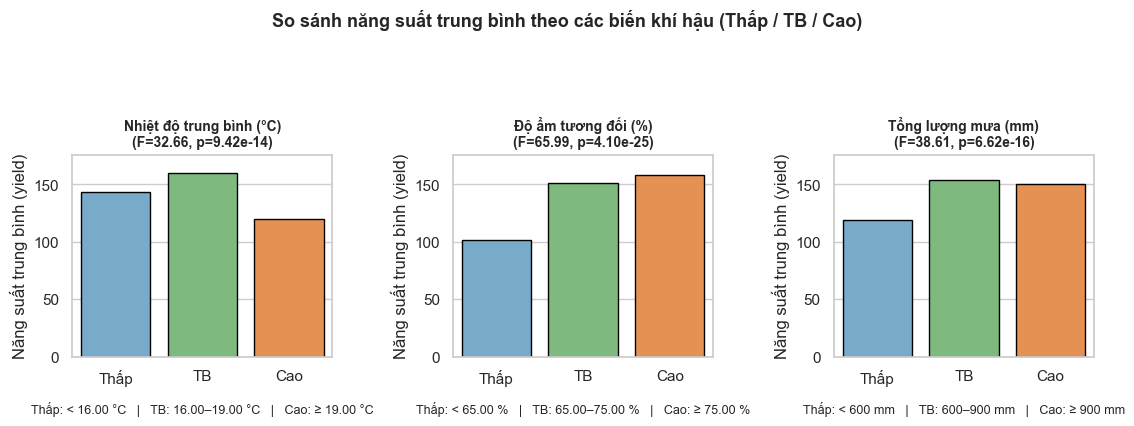

In [66]:
# === ANOVA gọn + vẽ 3 biểu đồ (kèm hiển thị khoảng Thấp/TB/Cao dưới mỗi subplot) ==
# 1) Input
weekly = weather_season_df.copy()
annual = yield_df.copy()
weekly.columns = [c.strip().lower() for c in weekly.columns]
annual.columns  = [c.strip().lower() for c in annual.columns]

# 2) Tổng hợp khí hậu theo (year, state_name)
climate = (
    weekly.groupby(["year","state_name"], observed=True)
          .agg(tavg=("tavg","mean"), rh=("rh","mean"), prcp_sum=("prcp_sum","sum"))
          .reset_index()
)

# 3) Merge năng suất
df = climate.merge(annual[["year","state_name","yield_grain"]],
                   on=["year","state_name"], how="inner")

# 4) Cấu hình ngưỡng (sửa ở đây nếu muốn)
BIN_CONFIG = {
    "tavg":     {"bins": [-np.inf, 16.0, 19.0, np.inf], "unit":"°C", "title":"Nhiệt độ trung bình (°C)"},
    "rh":       {"bins": [-np.inf, 65.0, 75.0, np.inf], "unit":"%",  "title":"Độ ẩm tương đối (%)"},
    "prcp_sum": {"bins": [-np.inf, 600.0, 900.0, np.inf], "unit":"mm", "title":"Tổng lượng mưa (mm)"},
}
LABELS = ("Thấp","TB","Cao")

def cut_with_bins(s, bins, labels=LABELS):
    return pd.cut(s, bins=bins, labels=labels, right=False, include_lowest=True)

def fmt_range(bins, unit, is_mm=False):
    f = (lambda x: f"{x:.0f}") if is_mm else (lambda x: f"{x:.2f}")
    b0, b1, b2, b3 = bins
    low  = f"< {f(b1)} {unit}" if np.isneginf(b0) else f"{f(b0)}–{f(b1)} {unit}"
    mid  = f"{f(b1)}–{f(b2)} {unit}"
    high = f"≥ {f(b2)} {unit}" if np.isposinf(b3) else f"{f(b2)}–{f(b3)} {unit}"
    return low, mid, high

rows = []
range_strings = {}

# 5) Chạy ANOVA cho từng biến và gom bảng
for var in ["tavg","rh","prcp_sum"]:
    bins = BIN_CONFIG[var]["bins"]
    unit = BIN_CONFIG[var]["unit"]
    rngs = fmt_range(bins, unit, is_mm=(var=="prcp_sum"))
    df[f"{var}_group"] = cut_with_bins(df[var], bins)

    # nhóm theo mức (Thấp/TB/Cao)
    grp_means = (df.groupby(f"{var}_group", observed=True)["yield_grain"]
                   .mean().reindex(LABELS).round(2))
    groups = [g["yield_grain"].values for _, g in df.groupby(f"{var}_group", observed=True)]
    F, p = stats.f_oneway(*groups)

    rows.append({
        "Biến": BIN_CONFIG[var]["title"],
        "F": round(F,2),
        "p": float(p),
        "Mean yield - Thấp": grp_means.get("Thấp", np.nan),
        "Mean yield - TB":   grp_means.get("TB",   np.nan),
        "Mean yield - Cao":  grp_means.get("Cao",  np.nan),
        "Khoảng Thấp": rngs[0], "Khoảng TB": rngs[1], "Khoảng Cao": rngs[2],
        "var": var  # để tiện vẽ
    })
    range_strings[var] = f"Thấp: {rngs[0]}   |   TB: {rngs[1]}   |   Cao: {rngs[2]}"

res_df = pd.DataFrame(rows)
# === In bảng ANOVA với p-value dạng khoa học (giống tiêu đề subplot) ===
def fmt_sci_table(df, p_cols=("p",), f_cols=("F",), digits_p=2, digits_f=2):
    out = df.copy()
    for c in p_cols:
        if c in out.columns:
            out[c] = out[c].apply(lambda x: f"{x:.{digits_p}e}")
    for c in f_cols:
        if c in out.columns:
            out[c] = out[c].apply(lambda x: f"{x:.{digits_f}f}")
    return out

display_df = fmt_sci_table(
    res_df.drop(columns=["var"]),  # giữ nguyên cột khoảng Thấp/TB/Cao
    p_cols=("p",),                 # cột p
    f_cols=("F",),                 # cột F
    digits_p=2,                    # ví dụ 9.42e-14
    digits_f=2                     # ví dụ 32.66
)

print("=== Kết quả ANOVA + Khoảng mỗi mức (Thấp/TB/Cao) ===")
print(display_df.to_string(index=False))

# 6) Vẽ 3 biểu đồ — FIX seaborn 0.14 (palette+có hue, legend=False)
sns.set(style="whitegrid", font_scale=1.0)
fig, axes = plt.subplots(1, 3, figsize=(11.5, 5))
palette = ["#6baed6","#74c476","#fd8d3c"]

# Tạo dữ liệu “dài” để vẽ cho chuẩn seaborn (tránh cảnh báo)
plot_frames = []
for r in rows:
    plot_frames.append(pd.DataFrame({
        "nhom": LABELS,
        "mean_yield": [r["Mean yield - Thấp"], r["Mean yield - TB"], r["Mean yield - Cao"]],
        "var": r["var"],
        "title": r["Biến"],
        "F": r["F"],
        "p": r["p"]
    }))
plot_df = pd.concat(plot_frames, ignore_index=True)

ymax = plot_df["mean_yield"].max() * 1.1
order_map = {"tavg":0, "rh":1, "prcp_sum":2}

for ax in axes:
    ax.set_ylim(0, ymax)

for var, ax in sorted(zip(order_map.keys(), axes), key=lambda x: order_map[x[0]]):
    sub = plot_df[plot_df["var"] == var]
    # dùng hue=sub["nhom"] + legend=False để tránh FutureWarning
    sns.barplot(data=sub, x="nhom", y="mean_yield", hue="nhom",
                ax=ax, palette=palette, edgecolor="black", legend=False)
    # tiêu đề + p-value làm tròn
    row = res_df[res_df["var"] == var].iloc[0]
    p_text = f"{row['p']:.2e}"
    ax.set_title(f"{row['Biến']}\n(F={row['F']:.2f}, p={p_text})",
                 fontsize=10, weight="bold")
    ax.set_xlabel(""); ax.set_ylabel("Năng suất trung bình (yield)")
    ax.text(0.5, -0.22, range_strings[var], transform=ax.transAxes,
            ha="center", va="top", fontsize=9)

fig.suptitle("So sánh năng suất trung bình theo các biến khí hậu (Thấp / TB / Cao)",
             fontsize=13, weight="bold", y=1.05)
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.show()




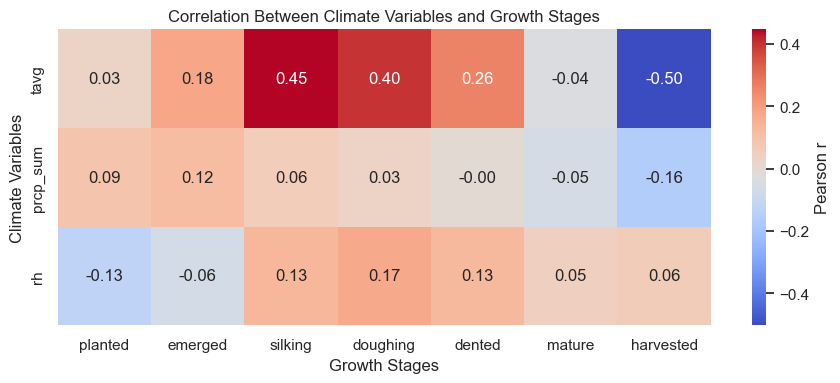

In [67]:

# Đọc dữ liệu
df = weather_season_df

# Xác định nhóm biến
growth_cols = ['planted', 'emerged', 'silking', 'doughing', 'dented', 'mature', 'harvested']
climate_cols = ['tavg', 'prcp_sum', 'rh']

# Bỏ các hàng có toàn 0 ở nhóm sinh trưởng
mask = (df[growth_cols].sum(axis=1) != 0)
df = df[mask]

# Tạo ma trận tương quan giữa hai nhóm
corr_matrix = pd.DataFrame(index=climate_cols, columns=growth_cols, dtype=float)

for c in climate_cols:
    for g in growth_cols:
        corr_matrix.loc[c, g] = df[c].corr(df[g])

# Vẽ heatmap
plt.figure(figsize=(9, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Pearson r'})
plt.title("Correlation Between Climate Variables and Growth Stages")
plt.xlabel("Growth Stages")
plt.ylabel("Climate Variables")
plt.tight_layout()
plt.show()


In [68]:
# Tạo biến giả large/small theo median
median_area = state_total["total_harvested"].median()
state_total["group"] = (state_total["total_harvested"] >= median_area).astype(int)

X = sm.add_constant(state_total["group"])
y = state_total["avg_yield"]

model = sm.OLS(y, X).fit()

# Dùng summary2 để dễ định dạng
summary = model.summary2()
summary.tables[1]["P>|t|"] = summary.tables[1]["P>|t|"].apply(lambda x: f"{x:.2e}")
print(summary)
print(f"T-test = {t_stat:.3f}, p = {p_val:.4f}")

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.168   
Dependent Variable: avg_yield        AIC:                172.5031
Date:               2025-11-13 10:34 BIC:                174.2839
No. Observations:   18               Log-Likelihood:     -84.252 
Df Model:           1                F-statistic:        4.437   
Df Residuals:       16               Prob (F-statistic): 0.0513  
R-squared:          0.217            Scale:              766.01  
------------------------------------------------------------------
          Coef.    Std.Err.     t      P>|t|     [0.025    0.975] 
------------------------------------------------------------------
const    129.1839    9.2256  14.0027  2.13e-10  109.6265  148.7413
group     27.4817   13.0470   2.1064  5.13e-02   -0.1767   55.1400
-----------------------------------------------------------------
Omnibus:               2.731        Durbin-Watson:          0.458
Prob(Omnibus):        

In [70]:
# --- Merge ---
# merge key an toàn tuyệt đối
if {'year','region'}.issubset(yield_df.columns) and {'year','region'}.issubset(weather_season_df.columns):
    merge_on = ['year','region']
elif 'year' in yield_df.columns and 'year' in weather_season_df.columns:
    merge_on = ['year']
else:
    raise ValueError("Không tìm được khóa merge.")



df = yield_df.merge(weather_season_df, how='inner')
df['prcp_mean_2'] = df.groupby(merge_on)['prcp_mean'].transform('mean')
df['tavg_mean']      = df.groupby(merge_on)['tavg'].transform('mean')
df['rh_mean']        = df.groupby(merge_on)['rh'].transform('mean')


# --- Tạo cột combined (chỉ để lưu/kiểm tra) ---
df['combined'] = df[['harvested_grain','prcp_mean_2','tavg_mean','rh_mean']].apply(lambda r: r.tolist(), axis=1)

# --- Chuẩn bị X, y ---
df_model = df[['yield_grain','harvested_grain','prcp_mean_2','tavg_mean','rh_mean',]].dropna()
y = df_model['yield_grain']
X = sm.add_constant(df_model[['harvested_grain','prcp_mean_2','tavg_mean','rh_mean']])

# --- Fit OLS ---
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            yield_grain   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     3530.
Date:                Thu, 13 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:34:54   Log-Likelihood:                -54946.
No. Observations:               11890   AIC:                         1.099e+05
Df Residuals:                   11885   BIC:                         1.099e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -232.2207      9.722    -